In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
set.seed(5805)
raisin_data <- read_csv("https://github.com/dylankim990/DSCI100_Group_2/raw/main/data/Raisin_Dataset.csv") %>% mutate(Class = as_factor(Class))
raisin_split <- initial_split(raisin_data, prop = 0.75 ,strata = Class)
raisin_training <- training(raisin_split)
raisin_testing <- testing(raisin_split)

#1. choose columns; forward selection 
#2. choose K; cross-validation
#3. predict and find accuracy on testing set; train and predict  

Parsed with column specification:
cols(
  Area = col_double(),
  MajorAxisLength = col_double(),
  MinorAxisLength = col_double(),
  Eccentricity = col_double(),
  ConvexArea = col_double(),
  Extent = col_double(),
  Perimeter = col_double(),
  Class = col_character()
)



#### 1. choose columns; forward selection 

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Perimeter,0.8507902
2,Class ~ Perimeter+Area,0.8597015
3,Class ~ Perimeter+Area+MajorAxisLength,0.8611501
4,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea,0.8611282
5,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity,0.8654741
6,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity+Extent,0.8640474
7,Class ~ Perimeter+Area+MajorAxisLength+ConvexArea+Eccentricity+Extent+MinorAxisLength,0.8581870


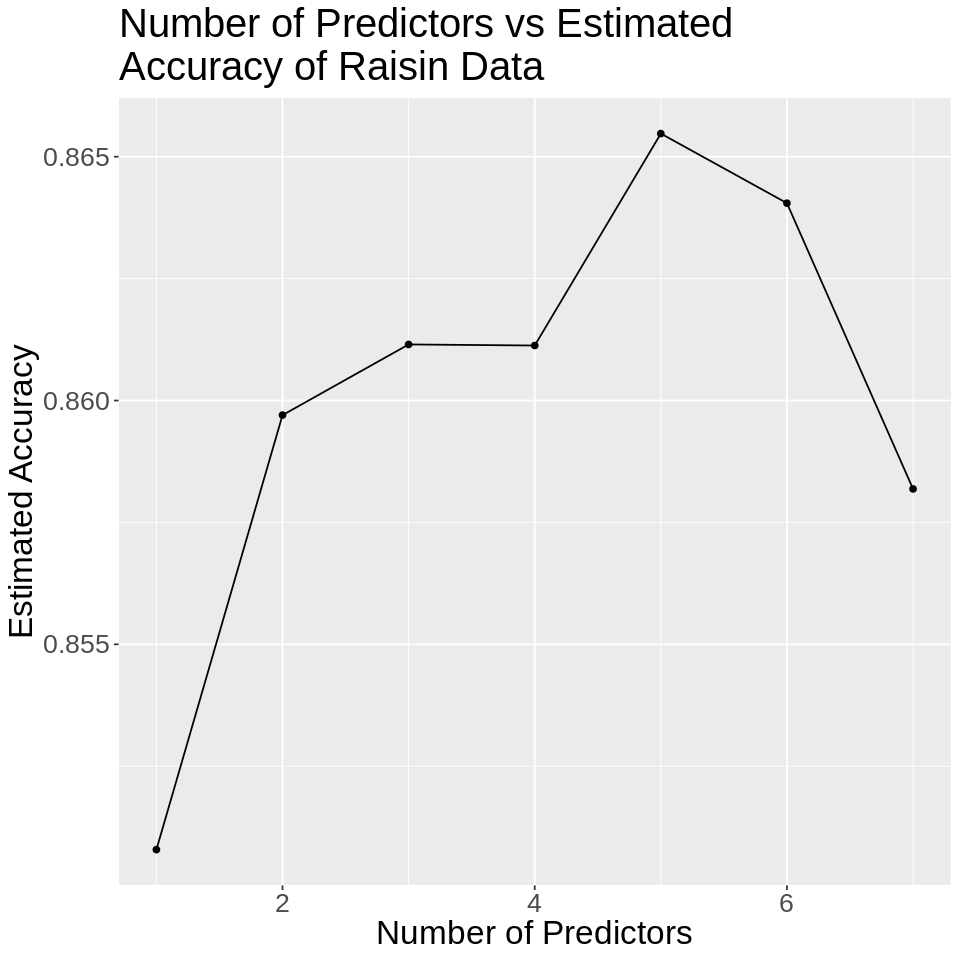

In [4]:
set.seed(5805)
raisin_split <- initial_split(raisin_data, prop = 0.75 ,strata = Class)
raisin_training <- training(raisin_split)
raisin_testing <- testing(raisin_split)

raisin_subset <- raisin_training %>%
  select(Area,
         MajorAxisLength, 
         MinorAxisLength, 
         Eccentricity, 
         ConvexArea, 
         Extent, 
         Perimeter, 
         Class)

names <- colnames(select(raisin_subset, -Class))
# creating an empty tibble which will store the accuracy results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())
# create a model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")
# 5-fold cross-validation
raisin_vfold <- vfold_cv(raisin_subset, v = 5, strata = Class)

# total # of predictors
n_total <- length(names)

# creating to store selected predictors
selected <- c()
set.seed(5805)
#loops to try all the models
# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()

#inner loop for model string for different combinations of predictors
    for (j in 1:length(names)) {
        # create a model string for the combinations of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
# created a recipe from the model string
        raisin_recipe <- recipe(as.formula(model_string), 
                                data = raisin_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())
        
# tune the KNN classifier with these predictors, 
# and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(raisin_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = raisin_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

# adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
        accuracies <- accuracies %>% 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
}
accuracies
options(repr.plot.width = 8, repr.plot.height = 8)

accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Predictors", y = "Estimated Accuracy", title = "Number of Predictors vs Estimated 
Accuracy of Raisin Data") +
    theme(text = element_text(size = 20))

accuracies_plot

Finding: use the three predictors: Perimeter, Area, and MajorAxisLength

#### 2. choose K; cross-validation

In [13]:
set.seed(5805)
raisin_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_recipe <- recipe(Class ~ Perimeter + Area + MajorAxisLength, data = raisin_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
#do I need scale? yes I need. Should I mention y I need the scale?

onetotwenty <- tibble(neighbors = seq(1,20))
raisin_vfold <- vfold_cv(raisin_training, v = 5, strata = Class)
#should I justify y I am using 5 of v?

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_spec) %>%
    tune_grid(resamples = raisin_vfold, grid = onetotwenty) %>%
#should I justify y I am using 10 ks?
    collect_metrics() %>%
    filter(.metric == "accuracy")

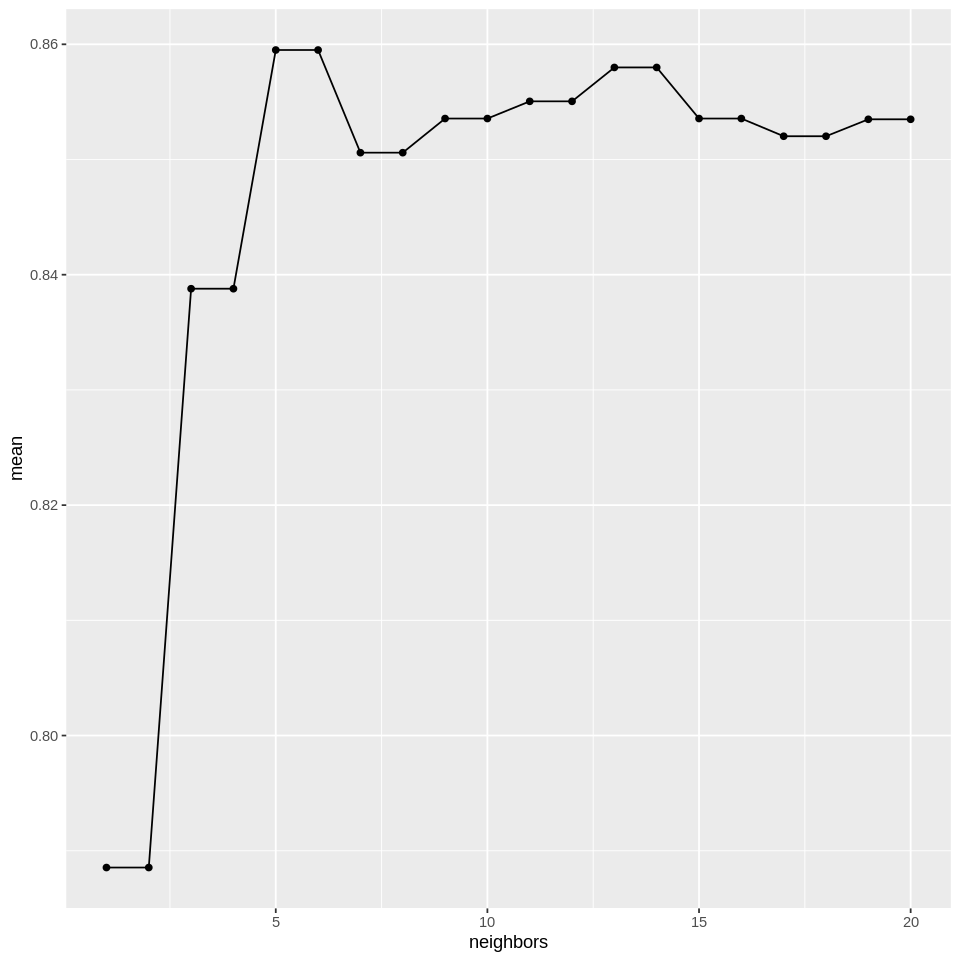

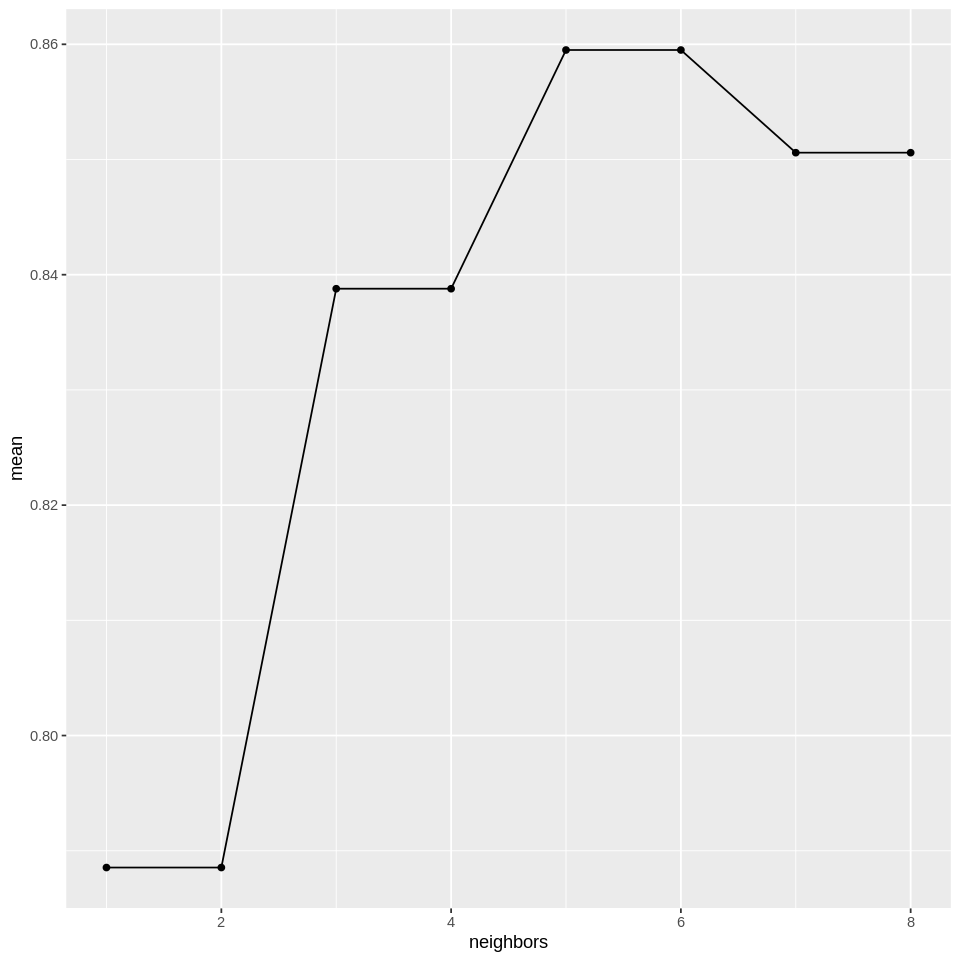

In [15]:
#near 10, there is two peaks of accuracy which seems like a valid accuracy without increasing K furher. Zoom in through filtering Ks under 15
#therefore, the K should 9. 
ggplot(raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

filtered_raisin_workflow <- filter(raisin_workflow, neighbors <= 8)
ggplot(filtered_raisin_workflow, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line()

Finding: Use 5 as K

#### 3. predict and find accuracy on testing set; train and predict  

In [19]:
set.seed(5805)
raisin_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

raisin_workflow <- workflow() %>%
    add_recipe(raisin_recipe) %>%
    add_model(raisin_best_spec) %>%
    fit(data = raisin_training) 

raisin_result <- raisin_workflow %>%
    predict(raisin_testing) %>%
    bind_cols(raisin_testing) 

raisin_accuracy <- raisin_result %>%
    metrics(truth = Class, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

raisin_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8526786


In [20]:
finding: accuracy is 0.8526786

ERROR: Error in parse(text = x, srcfile = src): <text>:1:19: unexpected symbol
1: finding: accuracy is
                      ^
